# Topic Map

In [139]:
import os
import pandas as pd
import re
import nltk
import openai
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from bertopic import BERTopic
from nltk import sent_tokenize, word_tokenize
# nltk.download('punkt')


pd.set_option('display.max_colwidth', None)
openai.api_key=os.environ['openai_api_key'] 
processed_dir = '../data/processed/'
os.makedirs(processed_dir + 'html', exist_ok = True)
transcription_dir_location_en = processed_dir + 'transcription/en/'

In [159]:
docs = []
timestamps = []
docs_word_count = []
# TODO sort by date

# the text contains spoken filler words that need removed 
stopwords = ['um', 'um,', 'mm,', 'eh', 'eh,', 'eh?', 'ah', 'ah,', 'mhm', 'mhm.', 'oh', 'oh,', 'oh.', 'huh?', 'hi']     
# RegExs for significant phrases 
FDI = re.compile(re.escape("fratelli d'italia"), re.IGNORECASE)
ninety_four = re.compile(re.escape("ninety four"), re.IGNORECASE)
one_hundred_and_ninety_four = re.compile(re.escape("one hundred and ninety-four"), re.IGNORECASE)

def remove_stop_words(sentence):
    text_tokens = sentence.split(" ")
    tokens_filtered = [word for word in text_tokens if not word.lower() in stopwords]
    return (" ").join(tokens_filtered)

def parse_text(file_location): 
    transcriptions_df = pd.read_json(file_location, convert_dates=['createTime'])
    transcription_text = transcriptions_df['transcript'][0]
    transcription_create_time = transcriptions_df['createTime'][0].strftime('%Y-%m-%d %H:%M:%S')
    word_count = len(transcription_text.split()) 
    # only analyse files with sentences with more then 27 words
    if word_count < 27:
        print(f'Small number of words: {file_location} {transcription_text}')
        return
    docs_word_count.append(word_count)
    for sentence in sent_tokenize(transcription_text):
        timestamps.append(transcription_create_time)
        sentence = FDI.sub('Brothers of Italy', sentence)
        sentence = ninety_four.sub('ninety-four', sentence)
        sentence = one_hundred_and_ninety_four.sub('194', sentence)
        sentence = remove_stop_words(sentence)                 
        docs.append(sentence)
    
for file_name in os.listdir(transcription_dir_location_en):
    parse_text(transcription_dir_location_en + file_name)

print(len(timestamps))
print(len(docs))

docs_dict = zip(timestamps, docs)
    
with open('docs-text.txt', 'w') as file: 
	file.writelines("% s % s\n" % (key, value) for key, value in docs_dict) 

docs_word_count

Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7147206448232074502.json gentlemen, It was the day of defeat. But this is not the day to get things done. Well, that wasn't really the case. That's fine. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7147263913200045317.json September twenty-fifth I've said it all. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7135145359629634822.json 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7144425341279341830.json I am
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7070073900100521222.json who goes M design, yo. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7144420910336953606.json 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7143163842665663749.json 
Small number of words: ../data/processed/transcription/en/Transcribe

[204,
 60,
 1133,
 174,
 1373,
 253,
 275,
 355,
 479,
 1641,
 110,
 73,
 221,
 518,
 111,
 267,
 108,
 217,
 119,
 99,
 302,
 248,
 690,
 36,
 559,
 118,
 323,
 164,
 488,
 277,
 185,
 55,
 196,
 795,
 555,
 241,
 206,
 52,
 316,
 131,
 145,
 549,
 215,
 789,
 28,
 128,
 456,
 51,
 34,
 76,
 110,
 517,
 306,
 83,
 242,
 486,
 37,
 55,
 113,
 482,
 928,
 495,
 168,
 369,
 247,
 327,
 506,
 131,
 258,
 161,
 185,
 30,
 466,
 44,
 157,
 1631,
 283,
 218,
 326,
 201,
 109,
 204,
 113,
 193,
 137,
 420,
 351,
 714,
 32,
 167,
 201,
 108,
 628,
 298,
 1029,
 65,
 275,
 153,
 152,
 563,
 257,
 318,
 109,
 355,
 295,
 208,
 196,
 161,
 554,
 670,
 229,
 159,
 336,
 266,
 166,
 329,
 254,
 63,
 253,
 134,
 724,
 278,
 600,
 149,
 76,
 416,
 476,
 547,
 517,
 178,
 218,
 1094,
 128,
 67,
 255,
 116,
 204,
 355,
 175,
 691,
 213,
 519,
 89,
 78,
 178,
 272,
 738,
 500,
 1299,
 266,
 76,
 342,
 181,
 273,
 113,
 631,
 91,
 272,
 591,
 87,
 555,
 34,
 259,
 64,
 353,
 112]

1) Pre-calculate Embeddings

In [20]:
from bertopic.backend import OpenAIBackend
# import spacy
# !python -m spacy download en_core_web_md
# nlp = spacy.load("en_core_web_md", exclude=['tagger', 'parser', 'ner', 
#                                             'attribute_ruler', 'lemmatizer'])
# embedding_model = OpenAIBackend('text-embedding-ada-002"')

# import gensim.downloader as api
# ft = api.load('fasttext-wiki-news-subwords-300')
# embedding_model = ft

# all-mpnet-base-v2 - best but slow
embedding_model = SentenceTransformer('all-mpnet-base-v2')

# embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

Stochastic Behaviour

In [4]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

Limit Number of Topics

In [27]:
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

Improving Default Representation

In [53]:
# max_df 0.7, 1.0 no english stop wrods
# vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))
#  stop_words="english" - seems to interfere with generating topics like 'abortion' and max_df=2, min_df=2, no idea what to tweak these to. 
vectorizer_model = CountVectorizer(max_df=2, min_df=2, ngram_range=(1, 3), max_features=1000)
vectorizer_model.fit_transform(docs)
# vectorizer_model.get_feature_names_out()

<2325x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 2000 stored elements in Compressed Sparse Row format>

In [78]:
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# GPT-3.5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
openai_model = OpenAI(model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

from bertopic.representation import ZeroShotClassification
candidate_topics = ['migrants', 'abortion', 'fake news', 'brothers of italy']
zero_shot_model = ZeroShotClassification(candidate_topics, model="facebook/bart-large-mnli")
# https://joeddav.github.io/blog/2020/05/29/ZSL.html

# representation_model = keybert_model, mmr_model

    # openai_model


representation_model = {
    'KeyBERT': keybert_model,
    # 'OpenAI': openai_model,  # Uncomment if you will use OpenAI
    'MMR': mmr_model,
    # 'POS': pos_model,
    'Zero': zero_shot_model,
}

## Seed Topics

In [81]:
seed_topic_list = [
    ['abortion', 'abort', 'aborts', '194', ],
    ['rape', 'raped'],
    ['election', 'government', 'vote'],
    ['bills', 'inflation'],
    ['immigration', 'migration', 'migrants', 'refugee', 'traffickers'],
    ['Italy', 'Italian', 'brothers'],
    ['climate' , 'environmental', 'ecological',  'sustainability'],
    ['fake', 'fake news', 'lies', 'journalism'],
    ['tax', 'income'],
    ['freedom'],
    ['pets', 'animals'], # added as pets get merge into the migrants topic                
    ]

In [157]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=True)

# POS = 43 topics
# topics=[4, 5, 15, 17, 19, 23, 24, 28] // Fake News

# KeyBert = 40

topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings

  # vectorizer_model=                       # Step 4 -  Tokenize topics. Don't do this! It removed the entire abortion topic.

  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  seed_topic_list= seed_topic_list,
  # Hyperparameters
  # top_n_words=5,
  # diversity=0.7,
  # nr_topics='auto', # < less topics
  verbose=True,
  n_gram_range=(1,3) # allows Brothers of Italy
  # min_topic_size=5
  # calculate_probabilities=False
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

2023-10-11 12:39:32,755 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-10-11 12:39:39,552 - BERTopic - Reduced dimensionality
2023-10-11 12:39:39,609 - BERTopic - Clustered reduced embeddings


,Topic,Count,Name,Representation,KeyBERT,MMR,Zero,Representative_Docs
0,-1,739,-1_government_this_but_me,"[government, this, but, me, be, not, are, work, very, have]","[government, important, the government, work, are, to the, families, that we, for the, on]","[government, this, but, me, be, not, are, work, very, have]","[government, this, but, me, be, not, are, work, very, have]","[For me now the priority is to confirm those measures for the whole of 2024, to see if we can do something more clearly for low incomes, for the pensioners most in difficulty, from the beginning we made the choice to concentrate the few resources on those who were more in difficulty, but at work, because this is also a cultural and multiplier signal that must be given., If it is true that the homeland is a mother, that mother is there in a moment like this and therefore I wanted to express the thanks of the nation that you and I represent for the work you do, for the sacrifices you make, for how you manage , with your work, your dedication and the difficulties that this entails, because they are personal sacrifices and sacrifices of which we are and are perfectly aware, which however give the nation extraordinary luster, great opportunities., The route is not covered by non-governmental organizations and therefore the government's measures on non-governmental organizations have nothing to do with this, with this matter, I point out to you and I believe you must bear witness to the fact that despite us continuing to work to stop the flows of illegal immigration, also to prevent people from dying, we have since the beginning of this government continued to save all the people we could save when we were aware that they were at risk.]"
1,0,262,0_italy_italian_in italy_government,"[italy, italian, in italy, government, brothers, the italian, italians, of italy, an, nation]","[italian government, the italian government, of the italian, of italy, italy in, the italian, italy, italy is, italy that, italian]","[italy, italian, in italy, government, brothers, the italian, italians, of italy, an, nation]","[brothers of italy, , , , , , , , , ]","[From the decree to protect strategic production sectors to the birth of the Committee for Made in Italy, passing through the battle that allowed us to avoid the exclusion of wine, red meat and cured meats from European funding for the promotion of agricultural products, we have reiterated that Italy intends to defend its infrastructure, its brand, its excellence from the two billion euros that we have allocated to interventions for the safety, adaptation and redevelopment of schools, of which seven hundred and ten million that we have released and one billion and two hundred million added from scratch until resources are increased to make universities more efficient for a total of one billion four hundred million., Jesus, Giorgia Meloni, J. Carron, Sanka Gesù, the president of Brothers of Italy left her parts preserved Italian Brothers of Italy and Draghi Brothers of Italy her parts and that the time and the deterioration, the the the the, the the the the the the surviving tragic, the Soviet Union for the misma bla of freedom, positioning of the current world and in what I don't know, we synergistically put in casts anti-democratic drift with palabras signatures that we don't always encounter if the group is Italian, European and even in the next one is the change represented for brothers of Italy, however, of Western freedom to maintain the farm during agnos and of garrisons the European conservative party which with the stories and American Israeli position in the Western field is crystal clear with the pink aggression against Ukraine, the contribute to bring if the Italian position in Europe and internationally our idea of ​​Europe and Slade is a political entity capable of representing an additional real value with less bureaucracy, the greats assumed that it shoots the future of Italy CSL dynamic and presides ove

Show the documents in a particular topic

In [158]:

interesting_topics=[1, 2, 5, 8, 9, 14, 23, 29, 30]
# If you want to change the topics to something else, whether that is merging them or removing outliers, 
# you can pass a custom list of topics to update them: topic_model.update_topics(docs, topics=my_updated_topics)
# topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
# topic_model.get_topic_info()
# representative_docs = topic_model.get_representative_docs(5)
# representative_docs

df[df['Topic'] == 3].head(50)


,Document,Topic
19,"we have begun to defend our borders from human traffickers, from support for ukraine to the mattei plan for africa, through over sixty contacts and meetings with the leaders of as many nations.",3
77,what are the measures?,3
134,it's mostly women.,3
261,"but refugees are not about welcoming a community, giving hospitality to a community that in italy sees many integrated people, respectful of our rules.",3
265,"you see, president, when there is a war it is the women and children who flee, the men tend to stay and fight.",3
266,and i say this because for years here we have been told that there was the tragedy of refugees faced with images of boats full of single men of working age.,3
267,"the images of these hours are a boulder on certain lies and coincidentally, faced with a clear distinction between refugees and economic migrants.",3
268,which first nations provide assistance?,3
278,"the decree provides for an increase in penalties for migrant trafficking, but above all provides for the introduction of a new type of crime relating to death or serious injuries, as a consequence of trafficking of illegal immigrants which provides for these criminals to be punished with a penalty up to thirty years of imprisonment.",3
279,"in the specific case, for example, of cutro, in the event that people die during one of these crossings and attention, an element that i consider very important, the crime will be prosecuted by italy even if committed outside the national borders.",3


In [100]:
fig = topic_model.visualize_barchart(width=280, height=330, top_n_topics=60, n_words=10, custom_labels=True)
fig.write_html(processed_dir + 'html/topic-word-scores.html')
fig

In [212]:
# new_topics = topic_model.reduce_outliers(docs, topics, strategy="embeddings", embeddings=embeddings)
# new_topics = topic_model.reduce_outliers(docs, topics)
# topic_model.update_topics(docs, topics=new_topics)
# topic_model.get_topic_info()

## Topic Labelling

Rename and format topic labels.

In [101]:
topic_labels = topic_model.generate_topic_labels(nr_words=3, topic_prefix=False, word_length=15, separator=', ')
topic_model.set_topic_labels(topic_labels)
topic_model.get_topic_info().head(3)
# llama2_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Llama2"].values()]
# topic_model.set_topic_labels(llama2_labels)
# print(topic_model.get_topic_info()['KeyBERT'][0])
# topic_model.set_topic_labels({1: "Abortion"})
# topic_model.set_topic_labels({2: "Immigration"})
# topic_model.set_topic_labels({3: "Fake News"})
# topic_model.set_topic_labels({4: "Freedom"})
# topic_model.set_topic_labels({14: "Taxes"})
# topic_model.set_topic_labels({14: "Cost of Living/Inflation"})
# topic_model.set_topic_labels({14: "Election Campaign"})
# topic_model.set_topic_labels({14: "Rape"})
# topic_model.set_topic_labels({14: "Climate Change"})
# topic_model.get_topic_info().head(20)

,Topic,Count,Name,CustomName,Representation,KeyBERT,MMR,Zero,Representative_Docs
0,-1,1086,-1_government_this_have_our,"government, this, have","[government, this, have, our, in the, be, of t...","[italy, government, italian, the government, f...","[government, this, have, our, in the, be, of t...","[government, this, have, our, in the, be, of t...",[from the extension of the solidarity fund for...
1,0,106,0_brothers_brothers of italy_brothers of_of italy,"brothers, brothers of ita, brothers of","[brothers, brothers of italy, brothers of, of ...","[italy brothers of, italy brothers, of italy c...","[brothers, brothers of italy, brothers of, of ...","[brothers of italy, , , , , , , , , ]","[with gianni forti, uncle of chico forti, an a..."
2,1,66,1_immigration_migrants_traffickers_illegal,"immigration, migrants, traffickers","[immigration, migrants, traffickers, illegal, ...","[ngos and therefore, ngos and, migrants which,...","[immigration, migrants, traffickers, illegal, ...","[migrants, , , , , , , , , ]",[the adolescence dot it site is a site that cl...


In [109]:
# merge topics
# topic_model.merge_topics(docs, topics_to_merge=[-1, 1])
# topic_model.get_topic_info().head(5)

In [ ]:

# %%time
# model = BERTopic(
#     n_gram_range=(1, 2),
#     vectorizer_model=vectorizer_model,
#     nr_topics='auto',
#     min_topic_size=10,
#     diversity=0.7,
#     seed_topic_list=[
#         ["experience", "bad", "good", "nice"],
#         ["place", "atmosphere", "toilet", "clean"],
#         ["staff", "waitress", "service"],
#         ["wait", "time", "long"],
#         ["food", "taste"]
#     ],
#     calculate_probabilities=True).fit(docs, corpus_embeddings)
# remove outliers
#  Comment out this line below if you decided to use the "propbabilities" strategy
# new_topics = model.reduce_outliers(docs, topics, strategy="c-tf-idf")


# Reduce outliers using the `probabilities` strategy (Uncomment to use this)
# #new_topics = model.reduce_outliers(docs, topics, probabilities=probabilities, strategy="probabilities")
# This line is to update the model with the latest topic assignment 
# model.update_topics(docs, topics=new_topics, vectorizer_model=vectorizer_model)

# df_topic_freq = model.get_topic_freq()
# topics_count = len(df_topic_freq) - 1
# df_topic_freq

In [17]:
topic_model.get_topic(11, full=True)

{'Main': [('abolish', 0.5794200533941609),
  ('proposal', 0.5369405674210438),
  ('ninety', 0.471150407786998),
  ('government', 0.41559406214151506),
  ('opposition', 0.41359911432732305),
  ('weeks', 0.4097118489104826),
  ('modify', 0.4097118489104826),
  ('intend', 0.3958949417785184),
  ('capable', 0.38501243162534654),
  ('office', 0.36999292903005215)],
 'KeyBERT': [('abolish', 0.51624155),
  ('reform', 0.41849333),
  ('ninety', 0.3477364),
  ('democracy', 0.3190127),
  ('opposition', 0.3137266),
  ('proposal', 0.309385),
  ('debate', 0.30352354),
  ('proposed', 0.28958642),
  ('proposals', 0.28786695),
  ('government', 0.27519163)],
 'MMR': [('abolish', 0.5794200533941609),
  ('proposal', 0.5369405674210438),
  ('ninety', 0.471150407786998),
  ('government', 0.41559406214151506),
  ('opposition', 0.41359911432732305),
  ('weeks', 0.4097118489104826),
  ('modify', 0.4097118489104826),
  ('intend', 0.3958949417785184),
  ('capable', 0.38501243162534654),
  ('office', 0.3699929290

In [94]:
topic_model.get_document_info(docs)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Another important chapter of our work in recen...,-1,-1_government_say_people_want,"[government, say, people, want, let, obviously...","[And maybe it's not me, I hope that after ten ...",government - say - people - want - let - obvio...,0.000000,False
1,The government has allocated over one billion ...,8,8_resources_funds_initiatives_fund,"[resources, funds, initiatives, fund, used, bi...","[For this reason, the objective of our work mu...",resources - funds - initiatives - fund - used ...,0.830680,False
2,"Because the scenes of degradation, abandonment...",12,12_safety_emergency_especially_lives,"[safety, emergency, especially, lives, state, ...",[We want to defend people who keep our beaches...,safety - emergency - especially - lives - stat...,1.000000,False
3,So we decided to increase the salaries and ove...,-1,-1_government_say_people_want,"[government, say, people, want, let, obviously...","[And maybe it's not me, I hope that after ten ...",government - say - people - want - let - obvio...,0.000000,False
4,We have decided to limit the possibility that ...,8,8_resources_funds_initiatives_fund,"[resources, funds, initiatives, fund, used, bi...","[For this reason, the objective of our work mu...",resources - funds - initiatives - fund - used ...,0.642233,False
...,...,...,...,...,...,...,...,...
2320,"Yesterday established a principle, namely that...",-1,-1_government_say_people_want,"[government, say, people, want, let, obviously...","[And maybe it's not me, I hope that after ten ...",government - say - people - want - let - obvio...,0.000000,False
2321,The approach of the European Council in the co...,16,16_european_european council_europe_council,"[european, european council, europe, council, ...",[The only way to seriously deal with this matt...,european - european council - europe - council...,1.000000,False
2322,"The approach that the European Council, put in...",16,16_european_european council_europe_council,"[european, european council, europe, council, ...",[The only way to seriously deal with this matt...,european - european council - europe - council...,1.000000,False
2323,Immigration is a European problem and needs a ...,4,4_immigration_people_rules_international law,"[immigration, people, rules, international law...",[This means firmly combating illegal immigrati...,immigration - people - rules - international l...,0.944187,False


In [103]:
fig = topic_model.visualize_topics(custom_labels=True)
fig.write_html(processed_dir + 'html/inter-topic-distance-map.html')
fig

## Visualise Topics

In [104]:
heatmap_fig = topic_model.visualize_heatmap(n_clusters=10,custom_labels=True)
heatmap_fig.write_html(processed_dir + 'html/similarity-matrix.html')
heatmap_fig

## Topics over time 

Make sure to use a limited number of unique timestamps (<100) as the c-TF-IDF representation will be calculated at each single unique timestamp. Having a large number of unique timestamps can take some time to be calculated. Moreover, there aren't many use-cased where you would like to see the difference in topic representations over more than 100 different timestamps.

In [109]:

topics_over_time = topic_model.topics_over_time(docs, timestamps)
intertopic_fig = topic_model.visualize_topics_over_time(topics_over_time=topics_over_time, topics=interesting_topics, custom_labels=True)
intertopic_fig.write_html(processed_dir + 'html/topics-over-time.html')
intertopic_fig

166it [00:13, 11.92it/s]


In [111]:
# sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
# embeddings = sentence_model.encode(docs, show_progress_bar=False)
# reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

# This is a way of summarising the document using the original caption in a way to group the sentence
# could also use date
# adjusted_docs = ["<b>" + title + "</b><br>" + doc[:100] + "..." 
#                  for doc, title in zip(docs, titles)]
# documents_and_topics_fig = topic_model.visualize_documents(docs, topics=topics, custom_labels=True, adjusted_docs=adjusted_docs)

documents_and_topics_fig = topic_model.visualize_documents(docs, topics=topics, custom_labels=True)
documents_and_topics_fig.write_html(processed_dir + 'html/documents-and-topics.html')
documents_and_topics_fig

In [239]:
doc_id = 41
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)
topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id], custom_labels=True)

100%|██████████| 3/3 [00:00<00:00,  7.74it/s]


,We,must,always,do,better,but,am,satisfied,with,the,fact,that,not,even,day,has,gone,by,Saturdays,Sundays,including,holidays,without,us,trying,to,give,at,least,one,answer,always,on,Italy,side
1_bit_echo_professionalism_girl,0.000,0.108,0.222,0.335,0.335,0.226,0.113,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2_ready_evening_happy_moment,0.101,0.101,0.101,0.101,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
18_capable_advantage_lunatic_merits,0.100,0.100,0.100,0.100,0.000,0.000,0.000,0.000,0.000,0.000,0.101,0.101,0.101,0.101,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.108,0.247,0.378,0.378,0.270,0.131,0.000
23_proud_celebration_sacrifice_politics,0.000,0.109,0.219,0.343,0.343,0.234,0.124,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
26_tones_propaganda_respect_adhesion,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.104,0.104,0.104,0.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
29_state_just_fair_assistance,0.125,0.125,0.125,0.125,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
32_income_citizen_minor_disabled,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.119,0.119,0.119,0.119,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
34_structured_proposal_counter_specious,0.000,0.000,0.000,0.112,0.112,0.112,0.112,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
40_principle_municipality_controls_bulk,0.139,0.139,0.139,0.139,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


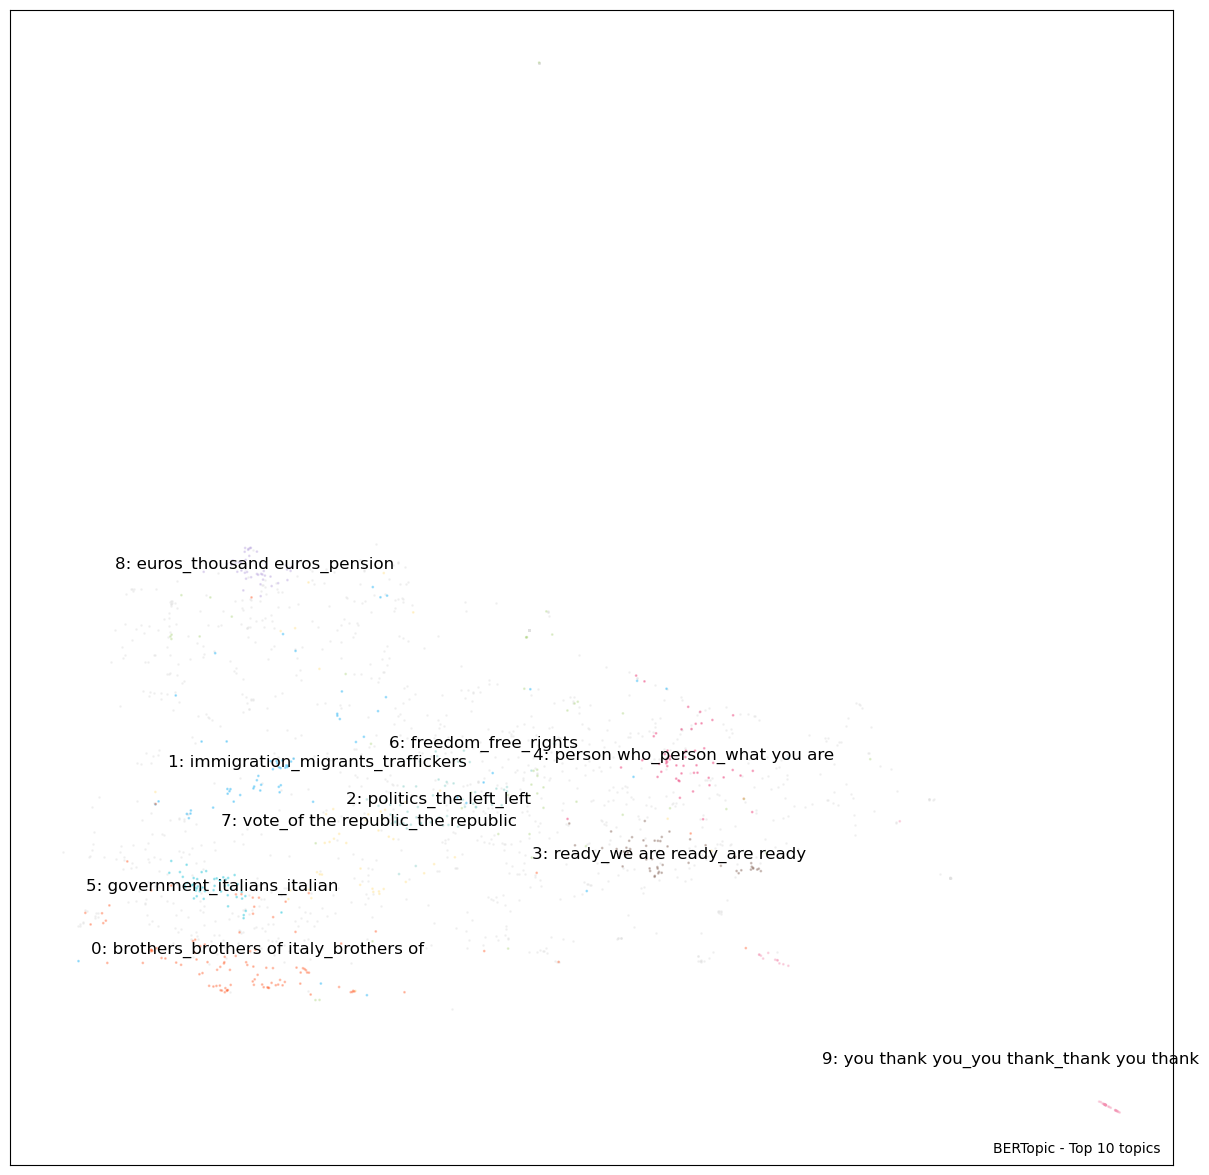

In [83]:
import matplotlib
import matplotlib.pyplot as plt

# Prepare data for plotting
embeddings = topic_model._extract_embeddings(docs, method="document")
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
df["topic"] = topics

# Plot parameters
top_n = 10
fontsize = 12

# Slice data
to_plot = df.copy()
to_plot[df.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]

# Visualize topics
cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                         '#03A9F4', # Blue
                                         '#4CAF50', # Green
                                         '#80CBC4', # FFEB3B
                                         '#673AB7', # Purple
                                         '#795548', # Brown
                                         '#E91E63', # Pink
                                         '#212121', # Black
                                         '#00BCD4', # Light Blue
                                         '#CDDC39', # Yellow/Red
                                         '#AED581', # Light Green
                                         '#FFE082', # Light Orange
                                         '#BCAAA4', # Light Brown
                                         '#B39DDB', # Light Purple
                                         '#F48FB1', # Light Pink
                                         ])

# Visualize outliers + inliers
fig, ax = plt.subplots(figsize=(15, 15))
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)

# Add topic names to clusters
centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
    topic = int(row[1].topic)
    text = f"{topic}: " + "_".join([x[0] for x in topic_model.get_topic(topic)[:3]])
    ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')

ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [ ]:
topic_model.hierarchical_topics(docs)

# semi supervised topics model
# topic_model.fit(docs, y = y)

# incremental topic modelling
# topic_model.partial_fit(docs)

# Dynamci topics topics over time
# topic_model.topics_over_time(docs, timestamps=)

# class based topic modelling
# topic_model.topics_per_class(docs, classes)
